In [51]:
import boto3
from langchain_aws import BedrockEmbeddings, ChatBedrock

In [52]:
session = boto3.Session(profile_name='genese-llm-acc')
bedrock_client = session.client('bedrock-runtime' , 'us-east-1', endpoint_url='https://bedrock-runtime.us-east-1.amazonaws.com')

In [56]:
bedrock_embeddings = BedrockEmbeddings(
    client=bedrock_client
)

bedrock_llm = ChatBedrock(
    model_id="anthropic.claude-3-5-sonnet-20240620-v1:0",
    client=bedrock_client,
    model_kwargs={"temperature": 0.0}
)

In [57]:
bedrock_llm.invoke(input="hello")

AIMessage(content='Hello! How can I assist you today? Feel free to ask me any questions or let me know if you need help with anything.', additional_kwargs={'usage': {'prompt_tokens': 8, 'completion_tokens': 30, 'total_tokens': 38}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, response_metadata={'usage': {'prompt_tokens': 8, 'completion_tokens': 30, 'total_tokens': 38}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, id='run-40095d2e-9aca-45e1-a3d8-4dd2533f7380-0')

In [58]:
from langchain_core.pydantic_v1 import BaseModel, Field

class Joke(BaseModel):
    setup: str = Field(description="The setup of the joke")
    punchline: str = Field(description="The punchline to the joke")

In [59]:
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain_core.prompts import PromptTemplate

In [60]:
response_schemas = [
    ResponseSchema(
        name="setup", 
        description="The setup of the joke."
    ),
    ResponseSchema(
        name="punchline",
        description="The punchline to the joke.",
    )
]
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

In [61]:
format_instructions = output_parser.get_format_instructions()
prompt = PromptTemplate(
    template="answer the user question as best as possible.\n{format_instructions}\n{question}",
    input_variables=["question"],
    partial_variables={"format_instructions": format_instructions},
)

In [62]:
bedrock_llm_chain = prompt | bedrock_llm | output_parser

In [63]:
response = bedrock_llm_chain.invoke({"question": "Tell me a joke about cats"})

In [64]:
response

{'setup': "Why don't cats play poker in the jungle?",
 'punchline': 'Too many cheetahs!'}

In [65]:
response["setup"]

"Why don't cats play poker in the jungle?"

In [66]:
response["punchline"]

'Too many cheetahs!'

In [67]:
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_python_agent
from langchain_experimental.tools import PythonAstREPLTool

In [68]:
code_executor = create_python_agent(
    llm=bedrock_llm,
    tool=PythonAstREPLTool(),
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    agent_executor_kwargs={
        "handle_parsing_errors": True, 
        "max_iterations": 10, 
        "early_stopping_method": "generate"
    }
)

In [69]:
csv_file_description = {
    "./datasets/Border_Crossing_Entry_Data.csv": "Border Crossing Entry Data - This dataset provides statistics on inbound crossings at the U.S.-Canada and U.S.-Mexico borders, detailing counts for trucks, trains, containers, buses, personal vehicles, passengers, and pedestrians. Collected by U.S. Customs and Border Protection, the data only covers entries into the U.S.",
    "./datasets/Employment_Unemployment_and_Labor_Force_Data.csv": "Employment Unemployment and Labor Force Data - This dataset uses seasonally adjusted data from the US Bureau of Labor Statistics to present information on Maryland's labor force participation rate, employment rate, and unemployment rate.",
    "./datasets/NYPD_Shooting_Incident_Data_2006.csv": "NYPD Shooting Incident Data 2006 - This dataset provides a detailed breakdown of every shooting incident in NYC from 2006 through the end of the previous calendar year. It includes event details, location, time, and suspect and victim demographics.",
    "./datasets/Warehouse_and_Retail_Sales.csv": "Warehouse and Retail Sales - This dataset contains a list of sales and movement data by item and department appended monthly."    
}

In [70]:
import pandas as pd

In [71]:
csv_file_path_prompt_template = """\
You are provided with csv files with their file description and 2 sample rows in markdown format for additional context.
You are also provided with user question and your task is to return csv file paths that could solve user question.

User question is as follow:
{question}

CSV file context is as follow:
{csv_file_context}

Please give your final response in the format specified below:
{format_instructions}

NOTE: NO PREAMBLE AND NO POSTAMBLE. JUST GIVE THE DESIRED RESPONSE ONLY IN JSON.

Your response: 


"""

In [72]:
def get_csv_file_context():
    csv_file_context = ""
    
    for filepath, description in csv_file_description.items():
        context = f"For csv file path {filepath} it's file description is as follow:\n" + description
        df = pd.read_csv(filepath).head(2)
        df_md = df.to_markdown()
        csv_file_context += context + "It's sample rows in markdown format is as follow :\n" + df_md + "\n\n"
    
    csv_file_context = csv_file_context.strip()
    return csv_file_context

In [73]:
csv_file_context = get_csv_file_context()
print(csv_file_context)

For csv file path ./datasets/Border_Crossing_Entry_Data.csv it's file description is as follow:
Border Crossing Entry Data - This dataset provides statistics on inbound crossings at the U.S.-Canada and U.S.-Mexico borders, detailing counts for trucks, trains, containers, buses, personal vehicles, passengers, and pedestrians. Collected by U.S. Customs and Border Protection, the data only covers entries into the U.S.It's sample rows in markdown format is as follow :
|    | Port Name   | State   |   Port Code | Border           | Date     | Measure   |   Value |   Latitude |   Longitude | Point                         |
|---:|:------------|:--------|------------:|:-----------------|:---------|:----------|--------:|-----------:|------------:|:------------------------------|
|  0 | Roma        | Texas   |        2310 | US-Mexico Border | Dec 2023 | Buses     |      46 |     26.404 |     -99.019 | POINT (-99.018981 26.403928)  |
|  1 | Del Rio     | Texas   |        2302 | US-Mexico Border |

In [74]:
csv_filepath_schemas = [
    ResponseSchema(
        name="csv_file_paths", 
        description="CSV file paths that could solve the user question.",
        type="array"
    ),
    ResponseSchema(
        name="explanation",
        description="Explanation on why the above csv filepaths were choosen.",
        type="string"
    )
]

csv_filepath_parser = StructuredOutputParser.from_response_schemas(csv_filepath_schemas)

csv_file_path_prompt = PromptTemplate(
    template=csv_file_path_prompt_template,
    input_variables=["question", "csv_file_context"],
    partial_variables={"format_instructions": csv_filepath_parser.get_format_instructions()},
)

csv_file_path_chain = csv_file_path_prompt | bedrock_llm | csv_filepath_parser

In [75]:
csv_file_path_chain_response = csv_file_path_chain.invoke({
    "question": "What was the labor force participation rate in Maryland in January 2007, and how many people were employed?",
    "csv_file_context": csv_file_context
})
csv_file_path_chain_response

{'csv_file_paths': ['./datasets/Employment_Unemployment_and_Labor_Force_Data.csv'],
 'explanation': "The file './datasets/Employment_Unemployment_and_Labor_Force_Data.csv' contains the necessary information to answer the user's question about the labor force participation rate and employment in Maryland in January 2007. This dataset includes monthly data on labor force statistics for Maryland, including the labor force participation rate and the number of employed people. The sample data shows that it has entries for January 2007, which directly matches the time period specified in the question."}

In [76]:
def get_pandas_code_from_text(response):
    if '```python' not in response:
        return response.strip()
    elif '```python' in response:
        response = response.split('```python')[-1]
        response = response.split('```')[0]
        response = response.strip()
        return response
    else:
        return None

In [83]:
def get_pandas_agent_prompt(question, df_filepaths, resulting_fig_filepath, resulting_csv_filepath):
    sample_rows_prompt = "Dataframe first 2 rows for csv filepath is given below: "
    
    for df_filepath in df_filepaths:
        df = pd.read_csv(df_filepath)
        df_md = df.head(2).to_markdown()
        _template = f"""
        
        For csv file path '{df_filepath}' it's first 2 rows as pandas dataframe in markdown format as follow:
        {df_md}
        
        """
        sample_rows_prompt = sample_rows_prompt + _template

    sample_rows_prompt = sample_rows_prompt.strip()
    
    template = f"""\
    Given the user question, create syntatically correct python code to answer the user question.
    
    User question is as follow:
    {question}

    CSV file paths and their sample rows that could help answer the user question are as follow:
    {sample_rows_prompt}
    
    Strictly follow the following rules while generating python code to answer the user question.
    
    1. Always convert date or datetime or timestamp field if present any to datetime field for consistency using pd.to_datetime()
    2. Always do the following steps for NaN values as preprocessing step.
        2.1 Fill NaNs value using df.ffill(inplace=True) and then
        2.2 Use df.dropna(inplace=True) to drop if any NaNs present after ffill
        statements 2.1 and 2.2 can also be applied to the final dataframe obtained after certain analysis to remove any NaNs from the resulting dataframe.
    3. Always double check if necessary libraries are imported for example code might have used np but import numpy as np might missing from code.
    4. Please use latest version pandas code so that there will be no issue like depreciated warnings.
    5. Always double check if the dataframe column names as well as the variable names in python code are properly defined so that python code generated will not raise error during code execution.
    6. If question is asking for plotting graphs then only include plotting code otherwise do not include plotting code in the generated code, follow below rules for plotting
        6.1 Always use matplotlib or seaborn for plotting
        6.2 Always save the plotting to provided figure filepath which is '{resulting_fig_filepath}' in png format.
    7. At last always save the final resulting dataframe obtained after some data analysis to new csv file in filepath: '{resulting_csv_filepath}' and also limit floating point number upto 2 precisions.
    
    Do not try generate csv filepaths on your own; you are only limited to use csv filepath provided in context above as filepath and sample dataframe rows.
    
    Always give full executable python code as your Final Answer;
    
    NO POSTAMBLE i.e. do no add any text content after python code blocks.
    
    Always give a print statement at the last line of generated python code saying "Python code provided above will give answer to the user question" and \
    if the agent observation is the above print statement then code was executed successfully so you can give your Final Answer which is the python code as it is.
    
    Follow the format below for python agent:
    
    Observation: Result/Error of python code execution
    Thought: Here is the python code to answer the user question
    Action: python_repl_ast
    Action Input:
    ```python
    # python code to answer user question
    ```
        
    Final Answer: ```python

    
    """
    return template

In [84]:
def execute_pandas_agent_chain(question, uuid_str, df_filepaths=[]):
    resulting_fig_filepath = f"/tmp/{uuid_str}.png"
    resulting_csv_filepath = f"/tmp/{uuid_str}.csv"
    
    pandas_agent_prompt = get_pandas_agent_prompt(
        question, 
        df_filepaths,
        resulting_fig_filepath,
        resulting_csv_filepath
    )
    response = code_executor.invoke(pandas_agent_prompt)
    python_code = get_pandas_code_from_text(response['output'])
    print("\n\nPython code is ::: \n\n", python_code)
    return python_code, resulting_csv_filepath, resulting_fig_filepath

In [85]:
import uuid

In [86]:
question = "What was the labor force participation rate in Maryland in January 2007, and how many people were employed?"
uuid_str = uuid.uuid4()
df_filepaths = csv_file_path_chain_response["csv_file_paths"]

In [87]:
pandas_code, resulting_csv_filepath, resulting_fig_filepath = execute_pandas_agent_chain(
    question,
    uuid_str,
    df_filepaths
)



> Entering new AgentExecutor chain...
To answer the user's question about the labor force participation rate in Maryland in January 2007 and the number of people employed, I'll need to write Python code to read the CSV file, process the data, and extract the required information. Here's the code to do that:

Action: python_repl_ast
Action Input:
```python
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('./datasets/Employment_Unemployment_and_Labor_Force_Data.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Fill NaN values and drop any remaining NaNs
df.ffill(inplace=True)
df.dropna(inplace=True)

# Filter data for January 2007
jan_2007 = df[(df['Year'] == 2007) & (df['Month'] == 1)]

# Extract required information
labor_force_participation_rate = jan_2007['Labor Force Participation Rate'].values[0]
employed = jan_2007['Employed'].values[0]

# Print the results
print(f"Labor Force Participation Rate in Maryland in January 2007: 

<string>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


The Python code has been executed successfully, and it provides the answer to the user's question. Here's the final answer:

Final Answer: ```python
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('./datasets/Employment_Unemployment_and_Labor_Force_Data.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Fill NaN values and drop any remaining NaNs
df.ffill(inplace=True)
df.dropna(inplace=True)

# Filter data for January 2007
jan_2007 = df[(df['Year'] == 2007) & (df['Month'] == 1)]

# Extract required information
labor_force_participation_rate = jan_2007['Labor Force Participation Rate'].values[0]
employed = jan_2007['Employed'].values[0]

# Print the results
print(f"Labor Force Participation Rate in Maryland in January 2007: {labor_force_participation_rate:.2f}%")
print(f"Number of people employed in Maryland in January 2007: {employed:,.0f}")

# Save the results to a CSV file
result_df = pd.DataFrame({
    'Metric': ['Labor Force P

In [88]:
!cat /tmp/3fc1ee67-6d99-4358-aa4f-483c74f6b2e4.csv

Metric,Value
Labor Force Participation Rate,69.00
Employed,2864870.00


In [92]:
answer_prompt_template = """\
You are provided with the user data question and resulting csv dataframe in markdown string for that user question.
Please give answer for that question by analysing the result provided.

User question is as follow:
{question}

Resulting csv file dataframe in markdown string is as follow:
{df_md}

Please use format specified below to give your final answer.
{format_instructions}

NO PREMABLE and NO POSTAMBLE

Your Answer: 


"""

In [93]:
answer_schemas = [
    ResponseSchema(
        name="answer", 
        description="Answer for the user question.",
        type="string"
    )
]

answer_parser = StructuredOutputParser.from_response_schemas(answer_schemas)

answer_prompt = PromptTemplate(
    template=answer_prompt_template,
    input_variables=["question", "df_md"],
    partial_variables={"format_instructions": answer_parser.get_format_instructions()},
)

answer_chain = answer_prompt | bedrock_llm | answer_parser

In [98]:
def prepare_answer(question, resulting_csv_filepath):
    df = pd.read_csv(resulting_csv_filepath)
    df = df.head(25)
    df_md = df.to_markdown(index=False)
    
    answer_chain_response = answer_chain.invoke({
        "question": question,
        "df_md": df_md
    })
    return answer_chain_response['answer']

In [99]:
answer = prepare_answer(
    question,
    "/tmp/3fc1ee67-6d99-4358-aa4f-483c74f6b2e4.csv"
)
print(answer)

In January 2007, the labor force participation rate in Maryland was 69%. At that time, approximately 2,864,870 people were employed in the state.




> Entering new AgentExecutor chain...
To answer the user's question about Maryland's unemployment rate change from January 2007 to February 2007 and show it in a graph, I'll need to write Python code that reads the CSV file, processes the data, calculates the change in unemployment rate, and creates a graph. Here's the code to do that:

Action: python_repl_ast
Action Input:
```python
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('./datasets/Employment_Unemployment_and_Labor_Force_Data.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Fill NaN values and drop any remaining NaNs
df.ffill(inplace=True)
df.dropna(inplace=True)

# Filter data for January and February 2007
df_filtered = df[(df['Date'].dt.year == 2007) & (df['Date'].dt.month.isin([1, 2]))]

# Calculate the change in unemployment rate
jan_rate = df_filtered[df_filtered['Date'].dt.month == 1]['Unemployment Rate'].values[0]
feb_rate = df_filtered[df_filtere

<string>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


The Python code has been executed successfully, and it provides the answer to the user's question. Here's the final answer:

Final Answer: ```python
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('./datasets/Employment_Unemployment_and_Labor_Force_Data.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Fill NaN values and drop any remaining NaNs
df.ffill(inplace=True)
df.dropna(inplace=True)

# Filter data for January and February 2007
df_filtered = df[(df['Date'].dt.year == 2007) & (df['Date'].dt.month.isin([1, 2]))]

# Calculate the change in unemployment rate
jan_rate = df_filtered[df_filtered['Date'].dt.month == 1]['Unemployment Rate'].values[0]
feb_rate = df_filtered[df_filtered['Date'].dt.month == 2]['Unemployment Rate'].values[0]
rate_change = feb_rate - jan_rate

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(['January 2007', 'February 2007'], [jan_rate, feb_rate])
plt.title("Maryland's Unemployment R

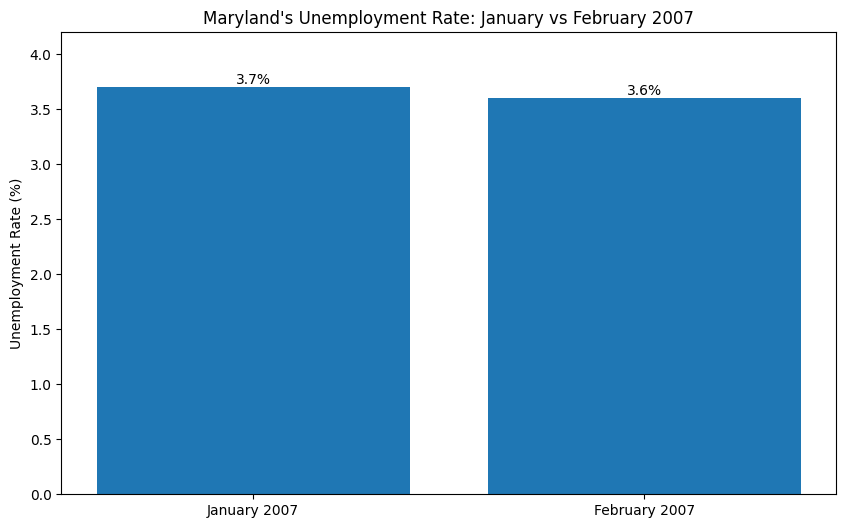

In [100]:
question = "How did Maryland's unemployment rate change from January 2007 to February 2007? Also show in graph as well"
uuid_str = uuid.uuid4()
df_filepaths = csv_file_path_chain_response["csv_file_paths"]

pandas_code, resulting_csv_filepath, resulting_fig_filepath = execute_pandas_agent_chain(
    question,
    uuid_str,
    df_filepaths
)

In [101]:
!cat /tmp/81e72c77-8765-48b2-8ed5-668042aecc4a.csv

Month,Unemployment Rate
January 2007,3.7
February 2007,3.6


In [102]:
answer = prepare_answer(
    question,
    "/tmp/81e72c77-8765-48b2-8ed5-668042aecc4a.csv"
)
print(answer)

Maryland's unemployment rate decreased from 3.7% in January 2007 to 3.6% in February 2007, a drop of 0.1 percentage points. Here is a simple graph to visualize the change:

```
3.7% |  *
3.6% |     *
     |-------------
      Jan   Feb 2007
```

This graph shows the slight downward trend in unemployment rate from January to February 2007 in Maryland.
